In [1]:
%matplotlib inline
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# Compare turbine models
with turbine measurements from `process_turbine_output.ipynb`

Available measurements:
- generator power
- generator torque
- rotor RPM

In [2]:
refdatadir = '/Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements'
modeldir = '/Users/equon/WakeDynamics/wakebench_wtg_response'
dirprefix = 'WAKEBENCH-'
simtypes = ['SSAM','RANS','DWMT','LES']

In [3]:
# cases = {
#     'neutral': '#008F00',
#     'stable': '#003C60',
#     'unstable': '#890001',
# }
cases = ['neutral','stable','unstable']

In [4]:
outputdpi = 300

In [5]:
colors = {
    'DTU_VANDERLAAN_RANS-MOST': 'limegreen',
    'DTU_VANDERLAAN_RANS-ABL': 'darkgreen',
    'IFPEN_CATHELAIN_SSAM': 'skyblue',
    'NREL_SHALER_DWMT': '#A046D0',
    'NREL_SHALER_DWMT-LES':'#F50DD6',          
    'PPEGmbH_SCHLEZ_RANS': 'lime',
    'NREL_DEBNATH_LES': '#E69B95',
    'SNL_MANIACI_LES': 'darkred',
    'FORWIND_KRUEGER_LES': 'darkgoldenrod',
    'IFPEN_CATHELAIN_LES': '#EA2A18',          
    'DTU_ANDERSEN_LES': 'gold',
    'NREL_HAMILTON_SSAM':'mediumblue',
    'NREL_QUON_SSAM':'dodgerblue',
}

In [6]:
from matplotlib.colors import to_rgba
def to_bw(rgba):
    """Convert color values from RGBA to black/white"""
    return np.dot(rgba[:3],[0.21,0.72,0.07]) # luminosity method
    #return np.mean(rgba[:3]) # average method
    #return (np.min(rgba[:3]) + np.max(rgba[:3]))/2

# use inverted b/w color for font
# - round to black or white for maximum contrast
fontcolors = {
    #key: str(1.0 - to_bw(to_rgba(val))) for key,val in colors.items()
    key: str(round(1.0 - to_bw(to_rgba(val)))) for key,val in colors.items()
}

In [7]:
# ids_in_order = None
ids_in_order = [
    "IFPEN_CATHELAIN_SSAM",
    'NREL_QUON_SSAM',                
    'NREL_HAMILTON_SSAM',
    "PPEGmbH_SCHLEZ_RANS",    
    "DTU_VANDERLAAN_RANS-MOST",                
    "DTU_VANDERLAAN_RANS-ABL",
    "NREL_SHALER_DWMT",
    "NREL_SHALER_DWMT-LES",                
    "DTU_ANDERSEN_LES",                
    "FORWIND_KRUEGER_LES",
    "SNL_MANIACI_LES",
    "IFPEN_CATHELAIN_LES",
    "NREL_DEBNATH_LES",
]

In [8]:
final_labels = {
    'DTU_ANDERSEN_LES': 'LES-EllipSys3D',
    'DTU_VANDERLAAN_RANS-MOST': 'RANS-EllipSys3D-MOST',
    'DTU_VANDERLAAN_RANS-ABL': 'RANS-EllipSys3D-ABL',
    'FORWIND_KRUEGER_LES': 'LES-PALM',
    'IFPEN_CATHELAIN_SSAM': 'SSA-FarmShadow',
    'IFPEN_CATHELAIN_LES': 'LES-SOWFA',
    'NREL_SHALER_DWMT': 'DWMT-FASTFarm',
    'NREL_SHALER_DWMT-LES':'DWMT-FASTFarm-LES',         
    'PPEGmbH_SCHLEZ_RANS': 'RANS-WakeBlaster',
    'NREL_DEBNATH_LES': 'LES-SOWFA-2',
    'SNL_MANIACI_LES': 'LES-NaluWind',
    'NREL_HAMILTON_SSAM':'SSA-GaussianIQ',
    'NREL_QUON_SSAM':'SSA-Gaussian',
}

In [9]:
# output data names
RotPwr = 'rotor_power_[kW]'
RotTq = 'rotor_torque_[N_m]'
GenPwr = 'generator_power_[kW]'
GenTq = 'generator_torque_[N_m]'
RotSpd = 'rotor_speed_[rpm]'
Thrust = 'aero_thrust_force_[N]'
CT = 'aero_thrust_coefficient_[-]'

In [10]:
# turbine quantities for estimating missing quantities
GenEff = 0.96349  # for converting from rotor power to generator power
GBRatio = 27.5647  # for converting rotor torque to generator torque

In [11]:
# calculations from openfast resulting power/thrust curve
refaero = '/Users/equon/WakeDynamics/wakebench_swift/wt_data/v3/Simulated_data/RotorPerformances_OF2.csv'
refdensity = 1.064032027823  # from SNLV27_AeroDyn15OF2.dat
velocity = {
    'neutral': 8.7,
    'stable': 4.8,
    'unstable': 6.7,
}
density = {
    'neutral': 1.02,
    'stable': 1.06,
    'unstable': 1.09,
}

## calculate reference openfast data

In [12]:
ofref = pd.read_csv(refaero,delim_whitespace=True).set_index('WS_[m/s]')

In [13]:
ref_power = {}
ref_thrust = {}
Pfun = interp1d(ofref.index, ofref['GenPower_[kW]'])
Tfun = interp1d(ofref.index, ofref['AeroThrust_[kN]'])
for case,Uref in velocity.items():
    # scale OpenFAST calculated power/thrust by the density
    # power/thrust are calculated from velocity at hub-height (without any rotor weighting)
    ref_power[case] = Pfun(Uref) * density[case]/refdensity
    ref_thrust[case] = Tfun(Uref) * density[case]/refdensity

In [14]:
ref_power, ref_thrust

({'neutral': 82.64712480499556,
  'stable': 14.864976604474073,
  'unstable': 41.2825892937379},
 {'neutral': 16.697645122911172,
  'stable': 5.66943460559393,
  'unstable': 11.326807920113515})

## catalog available model results

In [15]:
dirs = glob.glob(os.path.join(modeldir,dirprefix+'*'))

In [16]:
dirpaths = {os.path.split(dpath)[1][len(dirprefix):]: dpath for dpath in dirs}
dirpaths

{'NREL_QUON_SSAM': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_QUON_SSAM',
 'NREL_SHALER_DWMT-LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_SHALER_DWMT-LES',
 'IFPEN_CATHELAIN_SSAM': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_SSAM',
 'NREL_DEBNATH_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_DEBNATH_LES',
 'IFPEN_CATHELAIN_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_LES',
 'DTU_VANDERLAAN_RANS-MOST': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_VANDERLAAN_RANS-MOST',
 'DTU_ANDERSEN_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_ANDERSEN_LES',
 'DTU_VANDERLAAN_RANS-ABL': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_VANDERLAAN_RANS-ABL',
 'PPEGmbH_SCHLEZ_RANS': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-PPEGmbH_SCHLEZ_RANS',
 'NREL_HAMILTON_SSAM': '/Users/equon/WakeDynam

In [17]:
availsimtypes = []
for name in dirpaths.keys():
    simtype = name.split('_')[-1]
    simtype = simtype.split('-')[0]
    print(name,simtype)
    if simtype not in availsimtypes:
        availsimtypes.append(simtype)
print('Simulation types:',availsimtypes)
for simtype in simtypes:
    availsimtypes.remove(simtype)
assert(len(availsimtypes) == 0), 'simtypes list is incomplete'

NREL_QUON_SSAM SSAM
NREL_SHALER_DWMT-LES DWMT
IFPEN_CATHELAIN_SSAM SSAM
NREL_DEBNATH_LES LES
IFPEN_CATHELAIN_LES LES
DTU_VANDERLAAN_RANS-MOST RANS
DTU_ANDERSEN_LES LES
DTU_VANDERLAAN_RANS-ABL RANS
PPEGmbH_SCHLEZ_RANS RANS
NREL_HAMILTON_SSAM SSAM
FORWIND_KRUEGER_LES LES
NREL_SHALER_DWMT DWMT
SNL_MANIACI_LES LES
Simulation types: ['SSAM', 'DWMT', 'LES', 'RANS']


In [18]:
sims_of_type = {}
for simtype in simtypes:
    sims_of_type[simtype] = []
    for name in dirpaths.keys():
        suffix = name.split('_')[-1]
        if suffix.startswith(simtype):
            sims_of_type[simtype].append(name)
for simtype in simtypes:
    sims_of_type[simtype].sort()
print(sims_of_type)

{'SSAM': ['IFPEN_CATHELAIN_SSAM', 'NREL_HAMILTON_SSAM', 'NREL_QUON_SSAM'], 'RANS': ['DTU_VANDERLAAN_RANS-ABL', 'DTU_VANDERLAAN_RANS-MOST', 'PPEGmbH_SCHLEZ_RANS'], 'DWMT': ['NREL_SHALER_DWMT', 'NREL_SHALER_DWMT-LES'], 'LES': ['DTU_ANDERSEN_LES', 'FORWIND_KRUEGER_LES', 'IFPEN_CATHELAIN_LES', 'NREL_DEBNATH_LES', 'SNL_MANIACI_LES']}


In [19]:
if ids_in_order is None:
    ids_in_order = []
    for simtype in simtypes:
        for name in sims_of_type[simtype]:
            ids_in_order.append(name)
    print('Ordering outputs by simulation type:',ids_in_order)

## load all data

Note:
- Steady-state data end up being read as a series with the output quantities as the index (accessible by `df.loc[output]`)
- Time-accurate data end up being read into a dataframe with output quantities as columns (accessible simply by `df[output]`)

In [20]:
def load_turbine_output(dpath,case):
    flist = glob.glob(os.path.join(dpath,case,'*.txt'))
    print(dpath)
    if len(flist) == 0:
        print('  NO SUBMISSIONS FOUND')
        return None
    data = []
    for fpath in flist:
        print('  reading',os.path.split(fpath)[1])
        df = pd.read_csv(fpath, comment='#')
        if df.columns[0] == 'time_[s]':
            # have a time series
            df = df.set_index('time_[s]')
            assert (RotPwr in df.columns)
            assert (GenPwr in df.columns)
            assert (GenTq in df.columns)
            assert (RotSpd in df.columns)
            assert (CT in df.columns)
            if np.all(pd.isna(df[GenPwr])):
                # IFPEN_CATHELAIN_LES fix
                print('  ***generator power unavailable, estimating from rotor power***')
                df[GenPwr] = df[RotPwr] * GenEff
            if (Thrust not in df.columns) or np.any(np.isnan(df[Thrust])):
                # NREL_DEBNATH_LES fix
                # if thrust_force is available, then assume that's the aero_thrust_force
                #assert ('thrust_force_[N]' in df.columns)
                #print('  ***renaming thrust_force_[N]***')
                #df.rename(columns={'thrust_force_[N]': Thrust}, inplace=True)
                alt_thrust = 'total_thrust_force_[N]'
                if (alt_thrust in df.columns) and (not np.any(np.isnan(df[alt_thrust]))):
                    df[Thrust] = df[alt_thrust]
                    print('  ***'+Thrust+' unavailable, using '+alt_thrust+' instead***')
                else:
                    print('  ***'+Thrust+' not found***')
            if ((GenTq not in df.columns) or np.any(np.isnan(df[GenTq]))) \
                    and (RotTq in df.columns) and np.all(np.isfinite(df[RotTq])):
                print('  ***generator torque unavailable, estimating from rotor torque***')
                df[GenTq] = df[RotTq] / GBRatio
            if np.any(df[CT] > 5):
                # NREL_SHALER_DWMT-LES fix
                print('  ***setting {:d} large CT values to nan***'.format(df[CT].loc[df[CT]>5].count()))
                df.loc[df[CT]>5,CT] = np.nan
            data.append(df)
        elif df.columns[0] == 'name':
            # have steady-state values
            df = df.set_index('name')
            assert (RotPwr in df.index)
            assert (Thrust in df.index)
            assert (CT in df.index)
            if (GenPwr not in df.index) or np.isnan(df.loc[GenPwr].value):
                print('  ***generator power unavailable, estimating from rotor power***')
                df.loc[GenPwr] = df.loc[RotPwr] * GenEff
            if ((GenTq not in df.index) or np.isnan(df.loc[GenTq].value)) \
                    and (RotTq in df.index) and np.isfinite(df.loc[RotTq].value):
                print('  ***generator torque unavailable, estimating from rotor torque***')
                df.loc[GenTq] = df.loc[RotTq] / GBRatio
            data.append(df)
    return data

In [21]:
turbinedata = {}
for case in cases:
    print('\n'+case)
    print(len(case)*'-')
    turbinedata[case] = {}
    for name,dpath in dirpaths.items():
        data = load_turbine_output(dpath,case)
        if data is not None:
            turbinedata[case][name] = data


neutral
-------
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_QUON_SSAM
  reading NREL_QUON_SSAM_20191009_wtg_response_steady_state.txt
  ***generator power unavailable, estimating from rotor power***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_SHALER_DWMT-LES
  reading NREL_SHALER_DWMT_LES_20190931_wtg_response_Neutral.txt
  ***generator torque unavailable, estimating from rotor torque***
  ***setting 8 large CT values to nan***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_SSAM
  reading IFPEN_CATHELAIN_SSAM_20190808_wtg_response_steady_state.txt
  ***generator power unavailable, estimating from rotor power***
  ***generator torque unavailable, estimating from rotor torque***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_DEBNATH_LES
  reading NREL_DEBNATH_LES_20191010_wtg_response.txt
  ***aero_thrust_force_[N] unavailable, using total_thrust_force_[N] instead***
/Users/equon/WakeDynamics/wakebench_

  ***aero_thrust_force_[N] unavailable, using total_thrust_force_[N] instead***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_VANDERLAAN_RANS-ABL
  reading DTU_VANDERLAAN_RANS-ABL_20190910_wtg_response_steady_state.txt
  ***generator torque unavailable, estimating from rotor torque***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-PPEGmbH_SCHLEZ_RANS
  NO SUBMISSIONS FOUND
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_HAMILTON_SSAM
  reading NREL_QUON_SSAM_20191009_wtg_response_steady_state.txt
  ***generator power unavailable, estimating from rotor power***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-FORWIND_KRUEGER_LES
  reading FORWIND_KRUEGER_LES_20190904_wtg_response.txt
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_SHALER_DWMT
  reading NREL_SHALER_DWMT_TurbSim_20190910_wtg_response_Unstable_TS5.txt
  reading NREL_SHALER_DWMT_TurbSim_20190910_wtg_response_Unstable_TS4.txt
  reading NREL_SHALER_DWMT_Tu

In [22]:
refdata = {
    case: pd.read_csv(os.path.join(refdatadir,case+'_bootstrap_stats.csv'),index_col=0
                      ).rename(index={'GenPwr':GenPwr,'GenTq':GenTq,'rotorRPM':RotSpd})
    for case in cases
}

# PLOTS

In [23]:
plot_openfast_power = True
plot_openfast_thrust = False

In [24]:
# label properties
indent = '  '
labelsize = 'x-large'
#color = 'k'
weight = 'normal'

# bar properties
barheight = 0.75

IFPEN_CATHELAIN_SSAM neutral 86.03098559
NREL_QUON_SSAM neutral 85.6467987661223
NREL_HAMILTON_SSAM neutral 85.6467987661223
PPEGmbH_SCHLEZ_RANS neutral 89.95784966666668
DTU_VANDERLAAN_RANS-MOST neutral 91.94721
DTU_VANDERLAAN_RANS-ABL neutral 91.77773
NREL_SHALER_DWMT neutral 86.92832959246276
NREL_SHALER_DWMT-LES neutral 91.39848701434157
DTU_ANDERSEN_LES neutral 94.45007866456916
FORWIND_KRUEGER_LES neutral 81.10110569136934
SNL_MANIACI_LES neutral 99.96513989512621
IFPEN_CATHELAIN_LES neutral 102.92192135834391
NREL_DEBNATH_LES neutral 108.7669973650574
IFPEN_CATHELAIN_SSAM stable 15.2905863
NREL_QUON_SSAM stable 15.410547858142152
NREL_HAMILTON_SSAM stable 15.410547858142152
PPEGmbH_SCHLEZ_RANS stable 15.977875833333334
DTU_VANDERLAAN_RANS-MOST stable 15.90177
DTU_VANDERLAAN_RANS-ABL stable 15.4315
NREL_SHALER_DWMT stable 14.728743114895371
NREL_SHALER_DWMT-LES stable 14.698944609154314
NREL_DEBNATH_LES stable 19.827790267751606
IFPEN_CATHELAIN_SSAM unstable 42.43884403
NREL_QUON

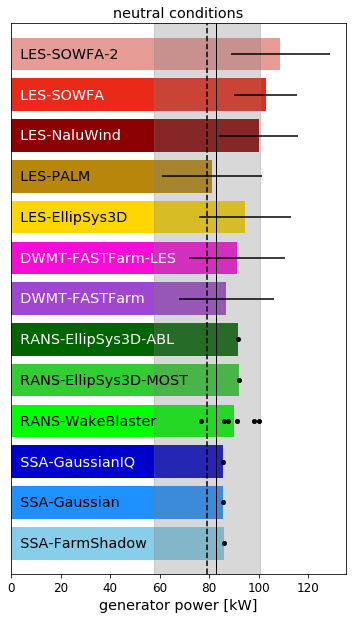

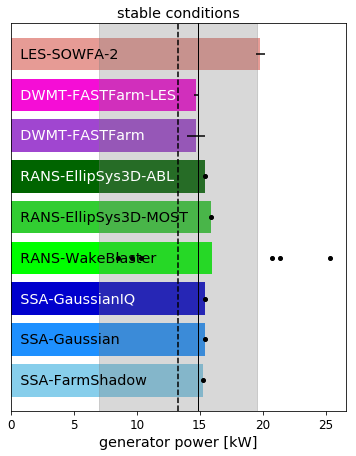

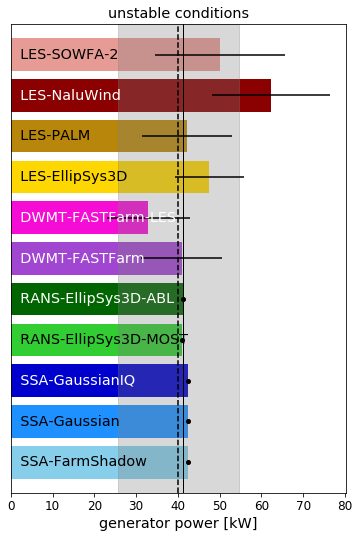

In [25]:
output = GenPwr

for case in cases:

    avail = turbinedata[case]
    Nresults = len(avail.keys())
    irow = 0
    fig,ax = plt.subplots(figsize=(6,6))
    for name in ids_in_order:
        if name in avail.keys():
            data = turbinedata[case][name]
            if data[0].index.name == 'time_[s]':
                # list of time histories of all quantities
                mean = np.mean([df[output].mean() for df in data])  # mean of means
                err = np.mean([df[output].std() for df in data])  # mean of stdevs
                ax.barh(irow, mean, xerr=err, color=colors[name])
                ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                        verticalalignment='center', fontsize=labelsize, fontweight=weight)
            else:
                # list of steady-state results
                data = [df.loc[output] for df in data]
                mean = np.mean(data)
                ax.barh(irow, mean, color=colors[name])
                ax.plot(data, len(data)*[irow], 'ko', markersize=4)
                ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                        verticalalignment='center', fontsize=labelsize, fontweight=weight)
            irow += 1
            print(name,case,mean)

    # plot reference data as shaded region
    refmean = refdata[case].loc[output]['mean']
    referr = refdata[case].loc[output]['stdev']
    ax.axvline(refmean, color='k', ls='--')
    ax.axvspan(refmean-referr, refmean+referr, color='0.5', alpha=0.3)
    
    if plot_openfast_power:
        ax.axvline(ref_power[case], color='k', lw=1)

    # axes formatting
    ax.tick_params(axis='y',width=0,labelleft=False)
    ax.tick_params(labelsize='large')
    ax.set_ylim((-0.75,irow-0.25))
    ax.set_xlabel(output.replace('_',' '), fontsize='x-large')
    ax.set_title(case+' conditions', fontsize='x-large')
    
    # adjust figure height to get bars to the same height
    fig.set_figheight((irow+0.5)*barheight)

    # save figure
    fig.savefig('compare_{:s}_{:s}.png'.format(output,case), bbox_inches='tight', dpi=outputdpi)

IFPEN_CATHELAIN_SSAM neutral 16.532700000000002
NREL_QUON_SSAM neutral 16.974355065000964
NREL_HAMILTON_SSAM neutral 16.974355065000964
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS neutral nan
DTU_VANDERLAAN_RANS-MOST neutral 18.166150000000002
DTU_VANDERLAAN_RANS-ABL neutral 18.13454
NREL_SHALER_DWMT neutral 17.31897580079359
NREL_SHALER_DWMT-LES neutral 17.76504395772199
DTU_ANDERSEN_LES neutral 19.00185691048239
FORWIND_KRUEGER_LES neutral 16.526805105541374
SNL_MANIACI_LES neutral 20.39760891582218
IFPEN_CATHELAIN_LES neutral 16.794295625859704
NREL_DEBNATH_LES neutral 18.138186783102913
IFPEN_CATHELAIN_SSAM stable 5.34101
NREL_QUON_SSAM stable 5.767644994068989
NREL_HAMILTON_SSAM stable 5.767644994068989
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS stable nan
DTU_VANDERLAAN_RANS-MOST stable 5.87928
DTU_VANDERLAAN_RANS-ABL stable 5.7626800000000005
NREL_SHALER_DWMT stable 5.6282608644523995
NREL_SHALER_DWMT-LES stable 5.559098188767088
NREL_DEBNATH_LES stable 6.329630

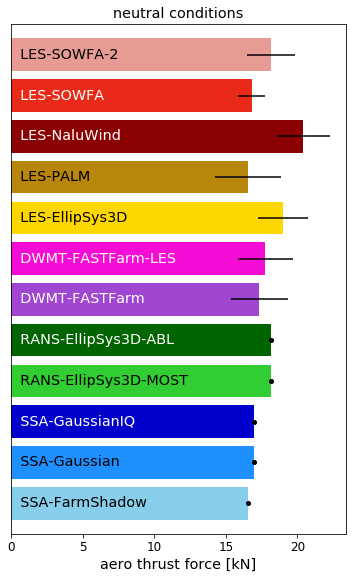

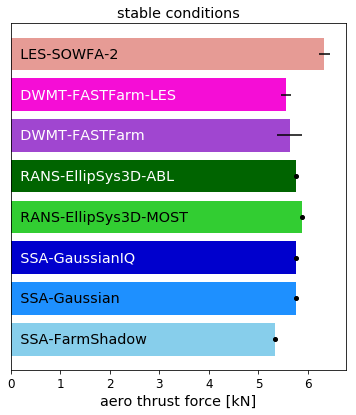

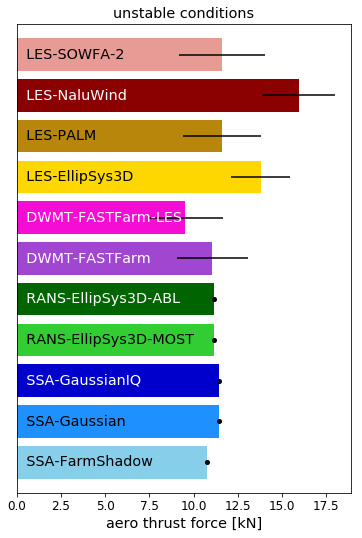

In [26]:
output = Thrust
norm = 1000. # convert to N to kN

for case in cases:

    avail = turbinedata[case]
    Nresults = len(avail.keys())
    irow = 0
    fig,ax = plt.subplots(figsize=(6,6))
    for name in ids_in_order:
        if name in avail.keys():
            data = turbinedata[case][name]
            if data[0].index.name == 'time_[s]':
                # list of time histories of all quantities
                mean = np.mean([df[output].mean()/norm for df in data])  # mean of means
                err = np.mean([df[output].std()/norm for df in data])  # mean of stdevs
                if np.isfinite(mean):
                    ax.barh(irow, mean, xerr=err, color=colors[name])
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***time-accurate data unavailable***')
            else:
                # list of steady-state results
                data = [df.loc[output]/norm for df in data]
                mean = np.mean(data)
                if np.isfinite(mean):
                    ax.barh(irow, mean, color=colors[name])
                    ax.plot(data, len(data)*[irow], 'ko', markersize=4)
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***steady data unavailable***')
            print(name,case,mean)

#     refmean = refdata[case].loc[output]['mean']
#     referr = refdata[case].loc[output]['stdev']
#     ax.axvline(refmean, color='k', ls='--')
#     ax.axvspan(refmean-referr, refmean+referr, color='0.5', alpha=0.3)
    if plot_openfast_thrust:
        ax.axvline(ref_thrust[case], color='k', lw=1)

    # axes formatting
    ax.tick_params(axis='y',width=0,labelleft=False)
    ax.tick_params(labelsize='large')
    ax.set_ylim((-0.75,irow-0.25))
    #ax.set_xlabel(output.replace('_',' '), fontsize='x-large')
    ax.set_xlabel(output.replace('_',' ').replace('[N]','[kN]'), fontsize='x-large')
    ax.set_title(case+' conditions', fontsize='x-large')

    # adjust figure height to get bars to the same height
    fig.set_figheight((irow+0.5)*barheight)

    # save figure
    fig.savefig('compare_{:s}_{:s}.png'.format(output,case), bbox_inches='tight', dpi=outputdpi)

IFPEN_CATHELAIN_SSAM neutral 0.748
NREL_QUON_SSAM neutral 0.7698829054505959
NREL_HAMILTON_SSAM neutral 0.7698829054505959
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS neutral nan
DTU_VANDERLAAN_RANS-MOST neutral 0.79187
DTU_VANDERLAAN_RANS-ABL neutral 0.790493
NREL_SHALER_DWMT neutral 0.7661152342192082
NREL_SHALER_DWMT-LES neutral 0.7574358329046226
  ***time-accurate data unavailable***
DTU_ANDERSEN_LES neutral nan
FORWIND_KRUEGER_LES neutral 0.7477579015058771
SNL_MANIACI_LES neutral 0.7707949759631715
IFPEN_CATHELAIN_LES neutral 0.7767610729023393
NREL_DEBNATH_LES neutral 0.8351248752798218
IFPEN_CATHELAIN_SSAM stable 0.764
NREL_QUON_SSAM stable 0.8189
NREL_HAMILTON_SSAM stable 0.8189
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS stable nan
DTU_VANDERLAAN_RANS-MOST stable 0.8419209999999999
DTU_VANDERLAAN_RANS-ABL stable 0.8252229999999999
NREL_SHALER_DWMT stable 0.8188366483451052
NREL_SHALER_DWMT-LES stable 0.815872923218532
NREL_DEBNATH_LES stable 0.635471003824534

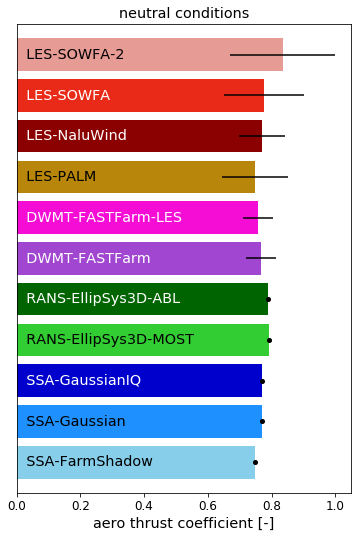

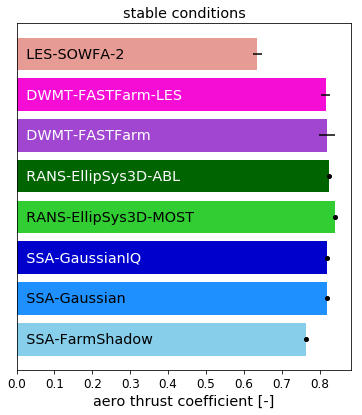

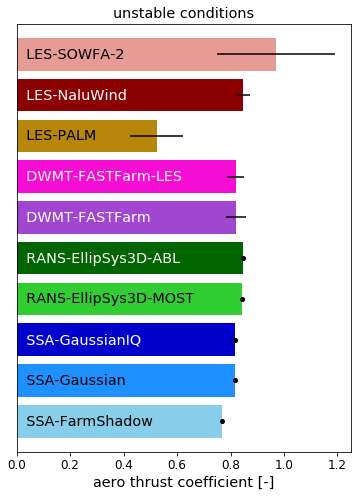

In [27]:
output = CT

for case in cases:

    avail = turbinedata[case]
    Nresults = len(avail.keys())
    irow = 0
    fig,ax = plt.subplots(figsize=(6,6))
    for name in ids_in_order:
        if name in avail.keys():
            data = turbinedata[case][name]
            if data[0].index.name == 'time_[s]':
                # list of time histories of all quantities
                mean = np.mean([df[output].mean() for df in data])  # mean of means
                err = np.mean([df[output].std() for df in data])  # mean of stdevs
                if np.isfinite(mean):
                    ax.barh(irow, mean, xerr=err, color=colors[name])
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***time-accurate data unavailable***')
            else:
                # list of steady-state results
                data = [df.loc[output] for df in data]
                mean = np.mean(data)
                if np.isfinite(mean):
                    ax.barh(irow, mean, color=colors[name])
                    ax.plot(data, len(data)*[irow], 'ko', markersize=4)
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***steady data unavailable***')
            print(name,case,mean)

    #ax.axvline(8/9., color='k', ls='--')

    # axes formatting
    ax.tick_params(axis='y',width=0,labelleft=False)
    ax.tick_params(labelsize='large')
    ax.set_ylim((-0.75,irow-0.25))
    #ax.set_xlabel(output.replace('_',' '), fontsize='x-large')
    ax.set_xlabel(output.replace('_',' ').replace('[N]','[kN]'), fontsize='x-large')
    ax.set_title(case+' conditions', fontsize='x-large')

    # adjust figure height to get bars to the same height
    fig.set_figheight((irow+0.5)*barheight)

    # save figure
    fig.savefig('compare_{:s}_{:s}.png'.format(output,case), bbox_inches='tight', dpi=outputdpi)

IFPEN_CATHELAIN_SSAM neutral 42.75
  ***steady data unavailable***
NREL_QUON_SSAM neutral nan
  ***steady data unavailable***
NREL_HAMILTON_SSAM neutral nan
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS neutral nan
DTU_VANDERLAAN_RANS-MOST neutral 43.547549
DTU_VANDERLAAN_RANS-ABL neutral 43.547549
NREL_SHALER_DWMT neutral 43.382354506347845
NREL_SHALER_DWMT-LES neutral 43.48510851747471
DTU_ANDERSEN_LES neutral 43.46958761099849
FORWIND_KRUEGER_LES neutral 43.13639862105841
SNL_MANIACI_LES neutral 43.5711548964895
IFPEN_CATHELAIN_LES neutral 43.30849999999942
NREL_DEBNATH_LES neutral 43.50549445036789
IFPEN_CATHELAIN_SSAM stable 24.56
  ***steady data unavailable***
NREL_QUON_SSAM stable nan
  ***steady data unavailable***
NREL_HAMILTON_SSAM stable nan
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS stable nan
DTU_VANDERLAAN_RANS-MOST stable 26.554909999999996
DTU_VANDERLAAN_RANS-ABL stable 26.554909999999996
NREL_SHALER_DWMT stable 26.67339109996155
NREL_SHALER_DWMT-LES sta

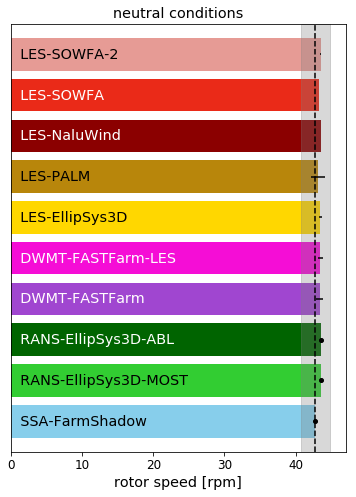

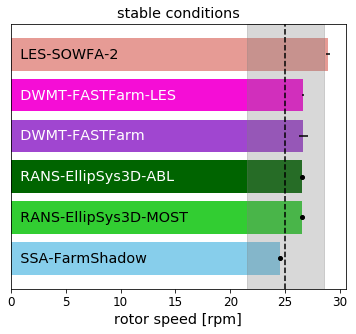

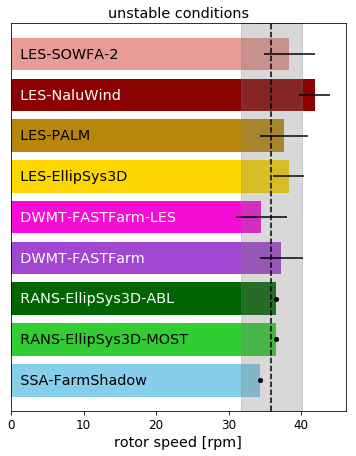

In [28]:
output = RotSpd

for case in cases:

    avail = turbinedata[case]
    Nresults = len(avail.keys())
    irow = 0
    fig,ax = plt.subplots(figsize=(6,6))
    for name in ids_in_order:
        if name in avail.keys():
            data = turbinedata[case][name]
            if data[0].index.name == 'time_[s]':
                # list of time histories of all quantities
                mean = np.mean([df[output].mean() for df in data])  # mean of means
                err = np.mean([df[output].std() for df in data])  # mean of stdevs
                if np.isfinite(mean):
                    ax.barh(irow, mean, xerr=err, color=colors[name])
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***time-accurate data unavailable***')
            else:
                # list of steady-state results
                data = [df.loc[output] for df in data]
                mean = np.mean(data)
                if np.isfinite(mean):
                    ax.barh(irow, mean, color=colors[name])
                    ax.plot(data, len(data)*[irow], 'ko', markersize=4)
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***steady data unavailable***')
            print(name,case,mean)

    refmean = refdata[case].loc[output]['mean']
    referr = refdata[case].loc[output]['stdev']
    ax.axvline(refmean, color='k', ls='--')
    ax.axvspan(refmean-referr, refmean+referr, color='0.5', alpha=0.3)

    # axes formatting
    ax.tick_params(axis='y',width=0,labelleft=False)
    ax.tick_params(labelsize='large')
    ax.set_ylim((-0.75,irow-0.25))
    ax.set_xlabel(output.replace('_',' '), fontsize='x-large')
    ax.set_title(case+' conditions', fontsize='x-large')

    # adjust figure height to get bars to the same height
    fig.set_figheight((irow+0.5)*barheight)

    # save figure
    fig.savefig('compare_{:s}_{:s}.png'.format(output,case), bbox_inches='tight', dpi=outputdpi)

IFPEN_CATHELAIN_SSAM neutral 723.5993861714439
  ***steady data unavailable***
NREL_QUON_SSAM neutral nan
  ***steady data unavailable***
NREL_HAMILTON_SSAM neutral nan
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS neutral nan
DTU_VANDERLAAN_RANS-MOST neutral 824.649279694682
DTU_VANDERLAAN_RANS-ABL neutral 823.1292196178447
NREL_SHALER_DWMT neutral 719.405769090809
NREL_SHALER_DWMT-LES neutral 799.7373792040894
DTU_ANDERSEN_LES neutral 787.0602039945547
FORWIND_KRUEGER_LES neutral 673.929837972647
SNL_MANIACI_LES neutral 794.6929228639311
IFPEN_CATHELAIN_LES neutral 854.4875989624293
NREL_DEBNATH_LES neutral 881.0432494240673
IFPEN_CATHELAIN_SSAM stable 223.8776406055571
  ***steady data unavailable***
NREL_QUON_SSAM stable nan
  ***steady data unavailable***
NREL_HAMILTON_SSAM stable nan
  ***steady data unavailable***
PPEGmbH_SCHLEZ_RANS stable nan
DTU_VANDERLAAN_RANS-MOST stable 233.8810144859186
DTU_VANDERLAAN_RANS-ABL stable 226.96455974489112
NREL_SHALER_DWMT stable 198.42

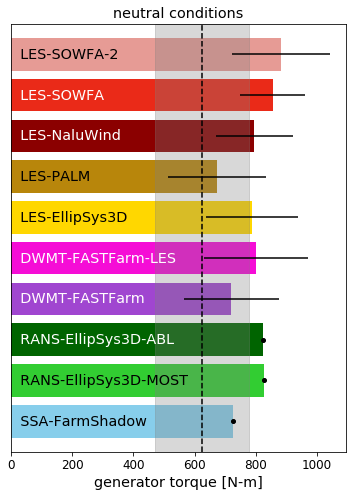

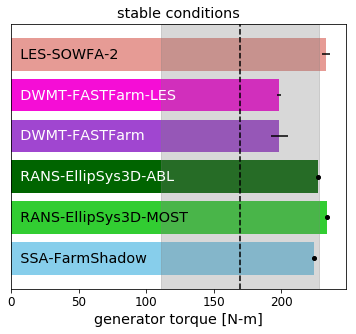

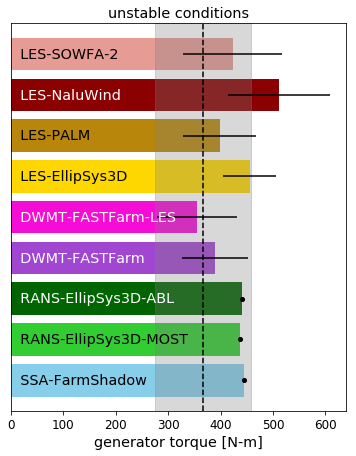

In [29]:
output = GenTq

for case in cases:

    avail = turbinedata[case]
    Nresults = len(avail.keys())
    irow = 0
    fig,ax = plt.subplots(figsize=(6,6))
    for name in ids_in_order:
        if name in avail.keys():
            data = turbinedata[case][name]
            if data[0].index.name == 'time_[s]':
                # list of time histories of all quantities
                mean = np.mean([df[output].mean() for df in data])  # mean of means
                err = np.mean([df[output].std() for df in data])  # mean of stdevs
                if np.isfinite(mean):
                    ax.barh(irow, mean, xerr=err, color=colors[name])
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***time-accurate data unavailable***')
            else:
                # list of steady-state results
                data = [df.loc[output] for df in data]
                mean = np.mean(data)
                if np.isfinite(mean):
                    ax.barh(irow, mean, color=colors[name])
                    ax.plot(data, len(data)*[irow], 'ko', markersize=4)
                    ax.text(0,irow, indent+final_labels[name], color=fontcolors[name],
                            verticalalignment='center', fontsize=labelsize, fontweight=weight)
                    irow += 1
                else:
                    print('  ***steady data unavailable***')
            print(name,case,mean)

    refmean = refdata[case].loc[output]['mean']
    referr = refdata[case].loc[output]['stdev']
    ax.axvline(refmean, color='k', ls='--')
    ax.axvspan(refmean-referr, refmean+referr, color='0.5', alpha=0.3)

    # axes formatting
    ax.tick_params(axis='y',width=0,labelleft=False)
    ax.tick_params(labelsize='large')
    ax.set_ylim((-0.75,irow-0.25))
    ax.set_xlabel(output.replace('_',' ').replace('[N m]','[N-m]'), fontsize='x-large')
    ax.set_title(case+' conditions', fontsize='x-large')

    # adjust figure height to get bars to the same height
    fig.set_figheight((irow+0.5)*barheight)

    # save figure
    fig.savefig('compare_{:s}_{:s}.png'.format(output,case), bbox_inches='tight', dpi=outputdpi)